**IMPORT LIBRARIES** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import shutil
from shutil import copyfile
import random

import keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator # from keras.preprocessing.image import ImageDataGenerator is deprecated
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

**Create function for plotting graph (plot_history)**

In [2]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

**Import dataset**

In [3]:
train_dir = '/kaggle/input/dogs-vs-cats/train/'
test_dir = '/kaggle/input/dogs-vs-cats/test/'

In [4]:
#use generators
#resize image
train_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [5]:
def process(image, label):
    image = tf.cast(image/255,tf.float32)
    return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)


1) VGG16 model

In [6]:
# Load the pre-trained VGG19 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: cat and dog

58889256/58889256 [==============================] - 0s 0us/step


In [7]:
# Create the final model
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [9]:
vgg16_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [10]:
# Train the model
history = vgg16_model.fit(train_ds,
                       epochs=20,
                       validation_data=validation_ds,
                       verbose=1)

Epoch 1/20
625/625 [==============================] - 159s 237ms/step - loss: 0.4126 - accuracy: 0.8708 - val_loss: 0.1749 - val_accuracy: 0.9296
Epoch 2/20
625/625 [==============================] - 79s 126ms/step - loss: 0.2194 - accuracy: 0.9118 - val_loss: 0.1517 - val_accuracy: 0.9392
Epoch 3/20
625/625 [==============================] - 72s 114ms/step - loss: 0.1885 - accuracy: 0.9201 - val_loss: 0.1462 - val_accuracy: 0.9360
Epoch 4/20
625/625 [==============================] - 71s 114ms/step - loss: 0.1697 - accuracy: 0.9292 - val_loss: 0.1478 - val_accuracy: 0.9360
Epoch 5/20
625/625 [==============================] - 71s 113ms/step - loss: 0.1524 - accuracy: 0.9366 - val_loss: 0.1500 - val_accuracy: 0.9388
Epoch 6/20
625/625 [==============================] - 71s 114ms/step - loss: 0.1468 - accuracy: 0.9387 - val_loss: 0.1453 - val_accuracy: 0.9414
Epoch 7/20
625/625 [==============================] - 71s 114ms/step - loss: 0.1496 - accuracy: 0.9354 - val_loss: 0.1589 - val_a

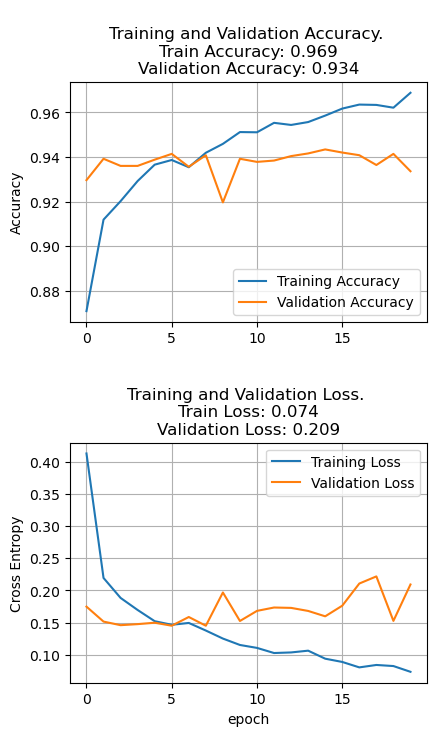

In [11]:
plot_history(history)


In [12]:
!mkdir "VGG16"

**Save model in particular location**

In [13]:
vgg16_model.save("/kaggle/working/VGG16")

2) CNN MODEL

In [14]:
from keras import Sequential 

In [15]:
#create a CNN model
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [16]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
history = model.fit(train_ds,epochs=10,validation_data = validation_ds)

Epoch 1/10
625/625 [==============================] - 56s 81ms/step - loss: 0.6499 - accuracy: 0.6169 - val_loss: 0.5894 - val_accuracy: 0.6948
Epoch 2/10
625/625 [==============================] - 56s 88ms/step - loss: 0.4831 - accuracy: 0.7681 - val_loss: 0.4542 - val_accuracy: 0.7962
Epoch 3/10
625/625 [==============================] - 51s 80ms/step - loss: 0.3778 - accuracy: 0.8282 - val_loss: 0.4696 - val_accuracy: 0.7918
Epoch 4/10
625/625 [==============================] - 51s 82ms/step - loss: 0.2587 - accuracy: 0.8882 - val_loss: 0.6547 - val_accuracy: 0.7772
Epoch 5/10
625/625 [==============================] - 54s 86ms/step - loss: 0.1514 - accuracy: 0.9380 - val_loss: 0.8254 - val_accuracy: 0.7692
Epoch 6/10
625/625 [==============================] - 53s 84ms/step - loss: 0.0928 - accuracy: 0.9651 - val_loss: 0.9676 - val_accuracy: 0.7796
Epoch 7/10
625/625 [==============================] - 52s 82ms/step - loss: 0.0651 - accuracy: 0.9772 - val_loss: 1.0288 - val_accuracy:

**plot graph**

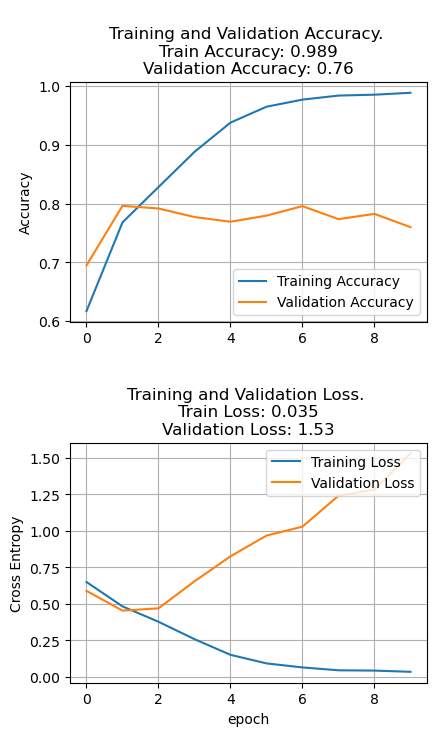

In [18]:
plot_history(history)

In [27]:
import cv2
import numpy as np
# Load and preprocess the image
image = cv2.imread('/kaggle/input/dogs-vs-cats/test/dogs/dog.10021.jpg')
image = cv2.resize(image, (256, 256))
image = image.astype('float32') / 255.0

# Reshape the image
image = np.expand_dims(image, axis=0)

# Make the prediction
prediction = model.predict(image)

# Convert the prediction to class label
class_label = 'dog' if prediction[0][0] >= 0.5 else 'cat'

print("Predicted class:", class_label)

1/1 [==============================] - 0s 22ms/step
Predicted class: dog


In [20]:
!mkdir "CNN"

In [21]:
model.save("/kaggle/working/CNN")